<h1 style="padding-top: 25px;padding-bottom: 25px;text-align: left; padding-left: 10px; background-color: #DDDDDD; 
    color: black;"> <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> AC295: Advanced Practical Data Science </h1>

## Practicum 2: Visual Question Answering

**Harvard University, Fall 2020**  
**Instructors**: Pavlos Protopapas  

### **Team: $\alpha\beta normal$ $Distri\beta ution$**
#### **Roht Beri, Eduardo Peynetti, Jessica Wijaya, Stuart Neilson**

## Basic Model for Training

### Install Packages

In [1]:
!pip3 install transformers

     |████████████████████████████████| 1.3MB 13.5MB/s 
     |████████████████████████████████| 1.1MB 42.3MB/s 
     |████████████████████████████████| 890kB 64.9MB/s 
     |████████████████████████████████| 2.9MB 62.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=41175d635258fd5cbc6cefaf8dd051a2e6fee3eea94093199f87393f8069d5d6
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


### Imports

In [2]:
import os
import requests
import tempfile
import zipfile
import shutil
import json
import time
import sys
import cv2
import numpy as np
import pandas as pd
from collections import Counter
from glob import glob
from google.colab import drive
from tqdm.notebook import trange, tqdm
import subprocess
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.python.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from keras.utils.layer_utils import count_params
from tensorflow_addons.metrics import F1Score

from transformers import BertTokenizer, TFBertModel

### Download Data

In [3]:
if not os.path.exists('/content/data'):
    os.mkdir('/content/data')

!gsutil cp -r gs://practicum2-abnormal-distribution/big2 /content/data

Copying gs://practicum2-abnormal-distribution/big2/answers.csv...
Copying gs://practicum2-abnormal-distribution/big2/train2014_tf/vaq_raw_train2014_00-of-10.records...
Copying gs://practicum2-abnormal-distribution/big2/train2014_tf/vaq_raw_train2014_01-of-10.records...
| [3 files][  1.1 GiB/  1.1 GiB]  133.3 MiB/s                                   
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying gs://practicum2-abnormal-distribution/big2/train2014_tf/vaq_raw_train2014_02-of-10.records...
Copying gs://practicum2-abnormal-distribution/big2/train2014_tf/vaq_raw_train2014_03-of-10.records...
Copying gs://practicum2-abnormal-distribution/big2/train2014_tf/vaq_raw_train2014_04-of-10.records...
Copying gs://practicum2-abnormal-distribution/big2/train2014_tf/vaq_raw_train2014_05-of-10.

In [4]:
#drive.mount('/content/drive', force_remount=False)
if not os.path.exists('/content/data'):
    os.mkdir('/content/data')

#!cp -r '/content/drive/My Drive/Practicum2Data/big2' /content/data

Mounted at /content/drive


### Utils

In [27]:
# we use the following to save the models
class JsonEncoder(json.JSONEncoder):
  def default(self, obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, decimal.Decimal):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        return super(JsonEncoder, self).default(obj)

# save_model saves everything. weights, statuses and results. 
def save_model(model,training_results,execution_time, learning_rate, epochs, optimizer, evaluation_results,
               path="/content/drive/My Drive/Practicum2Data/models"):
  model_name = model.name
  # Get the model train history
  model_train_history = training_results.history

  # Ensure path exists
  if not os.path.exists(path):
      os.mkdir(path)

  # Save the enitire model (structure + weights)
  #model.save(os.path.join(path,model_name+".hdf5"))

  # Save only the weights
  model.save_weights(os.path.join(path,model_name+".h5"))

  # Save the structure only
  #model_json = model.to_json()
  #with open(os.path.join(path,model_name+".json"), "w") as json_file:
  #    json_file.write(model_json)
    
  model_size = get_model_size(model_name=model_name)

  # Save model history
  with open(os.path.join("models",model_name+"_train_history.json"), "w") as json_file:
      json_file.write(json.dumps(model_train_history,cls=JsonEncoder))

  trainable_parameters = count_params(model.trainable_weights)
  non_trainable_parameters = count_params(model.non_trainable_weights)
  total_params = trainable_parameters + non_trainable_parameters

  # Save model metrics
  metrics ={
      "total_params":total_params,
      "execution_time":execution_time,
      "loss":evaluation_results[0],
      "accuracy":evaluation_results[1],
      "model_size":model_size,
      "learning_rate":learning_rate,
      "epochs":epochs,
      "optimizer":type(optimizer).__name__,
      "name": model_name,
      "id": int(time.time())
  }

  with open(os.path.join("models",model.name+"_metrics.json"), "w") as json_file:
      json_file.write(json.dumps(metrics,cls=JsonEncoder))

def get_model_size(path="models",model_name="model01"):
  model_size = os.stat(os.path.join(path,model_name+".hdf5")).st_size
  return model_size

def evaluate_model(model,test_data, training_results,execution_time, learning_rate, epochs, 
                   optimizer,save=True, 
                   loss_metrics=["loss","val_loss"],
                   acc_metrics=["accuracy","val_accuracy"]):
    
  # Get the model train history
  model_train_history = training_results.history
  # Get the number of epochs the training was run for
  num_epochs = len(model_train_history[loss_metrics[0]])

  # Plot training results
  fig = plt.figure(figsize=(15,5))
  axs = fig.add_subplot(1,2,1)
  axs.set_title('Loss')
  # Plot all metrics
  for metric in loss_metrics:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()
  
  axs = fig.add_subplot(1,2,2)
  axs.set_title('Accuracy')
  # Plot all metrics
  for metric in acc_metrics:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()

  plt.show()
  
  # Evaluate on test data
  evaluation_results = model.evaluate(test_data, return_dict=True)
  print(evaluation_results)

  evaluation_results = [evaluation_results[loss_metrics[0]], evaluation_results[acc_metrics[0]]]
  
  if save:
      # Save model
      save_model(model,training_results,execution_time, learning_rate, epochs, optimizer, evaluation_results)
  
  return evaluation_results

In [13]:
# Get Top K answers
def get_top_K_answers(k):
    answers = pd.read_csv("/content/data/big2/answers.csv", index_col=0)
    answers = answers.iloc[:k]
    return answers

In [14]:
# Function to parse data features
def _parse_features_function(example):
    # Parse the input tf.train.Example proto using the dictionary above.
    tf_records_features = {
        'image_raw': tf.io.FixedLenFeature([], tf.string), 
        'question' : tf.io.FixedLenFeature([], tf.string),
        'input_ids': tf.io.FixedLenFeature([], tf.string),
        'token_type_ids': tf.io.FixedLenFeature([], tf.string),
        'attention_mask': tf.io.FixedLenFeature([], tf.string), 
        'answer': tf.io.FixedLenFeature([], tf.int64)
    }
    return tf.io.parse_single_example(example, tf_records_features)


# Filter if answer is no
def filter_fn(x):
    return x['answer'] < k


# Read image and resize it
def read_and_decode(img):
    img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
    img = tf.cast(img, tf.float32)/255.0
    return img


# Structure the data for training
def structure_data(data):
    image = data['image_raw']
    image = read_and_decode(image)
    
    input_ids = tf.io.decode_raw(data['input_ids'], tf.int32)
    attention_mask = tf.io.decode_raw(data['attention_mask'], tf.int32)
    token_type_ids = tf.io.decode_raw(data['token_type_ids'], tf.int32)
    
    answer = data['answer']

    return ((image, (input_ids, token_type_ids, attention_mask)), answer)

### Important Variables and Constants

In [7]:
# Constants
IMG_WIDTH = 224
IMG_HEIGHT = 224
IMG_CHANNELS = 3

AUTOTUNE = tf.data.experimental.AUTOTUNE

# Pipeline variables
k = 10
batch_size = 32
train_buffer_size = 32
val_buffer_size = 32
prefetch = AUTOTUNE

### Get Top Answers

In [8]:
top_answers = get_top_K_answers(k)
TOP_ANSWERS = tf.constant(top_answers)

### Build Pipeline

In [9]:
# ############## #
# # Train data # #
# ############## #
tfrecords_pattern_path = "/content/data/big2/train2014_tf/vaq_raw_train2014_*-of-*.records"
train_files = tf.io.matching_files(tfrecords_pattern_path)
train_files = tf.random.shuffle(train_files)
train_shards = tf.data.Dataset.from_tensor_slices(train_files)

train = train_shards.interleave(tf.data.TFRecordDataset)
train = train.map(_parse_features_function, num_parallel_calls=AUTOTUNE)
train = train.filter(filter_fn)
train = train.map(structure_data, num_parallel_calls=AUTOTUNE)
#train = train.shuffle(buffer_size=train_buffer_size)
train = train.batch(batch_size)
#train = train.cache().prefetch(prefetch)

# ################### #
# # Validation data # #
# ################### #
tfrecords_pattern_path = "/content/data/big2/val2014_tf/vaq_raw_val2014_*-of-*.records"
val_files = tf.io.matching_files(tfrecords_pattern_path)
val_files = tf.random.shuffle(val_files)
val_shards = tf.data.Dataset.from_tensor_slices(val_files)

valid = val_shards.interleave(tf.data.TFRecordDataset)
valid = valid.map(_parse_features_function, num_parallel_calls=AUTOTUNE)
valid = valid.filter(filter_fn)
valid = valid.map(structure_data, num_parallel_calls=AUTOTUNE)
#valid = valid.shuffle(buffer_size=val_buffer_size)
valid = valid.batch(batch_size)
#valid = valid.cache().prefetch(prefetch)

### Build Model

In [16]:
def build_vqa_model(image_height, image_width, num_channels, num_classes):
    # Handle to pretrained model (Use a different model here)
    input_shape=[image_height, image_width, num_channels]
    resnet = keras.applications.VGG19(
        include_top=False, 
        weights='imagenet', 
        input_shape=input_shape
    )
    resnet.trainable = False
    image_hidden_states = layers.Flatten()(resnet.output)
    image_hs = layers.Lambda(lambda x: K.l2_normalize(x,axis=1))(image_hidden_states)

    input_ids = layers.Input(shape=(24,), dtype=tf.int32)
    token_type_ids = layers.Input(shape=(24,), dtype=tf.int32)
    attention_mask = layers.Input(shape=(24,), dtype=tf.int32)
    bert = TFBertModel.from_pretrained('bert-base-uncased', return_dict=True)
    bert.trainable = False
    question = bert(
        input_ids, 
        token_type_ids=token_type_ids, 
        attention_mask=attention_mask
    )
    question_hs = layers.Flatten()(question[1])
    #question_hs = layers.Lambda(lambda x: K.l2_normalize(x,axis=1))(question_hs)

    cross_hs = layers.concatenate([image_hs, question_hs])

    x = layers.Dense(1024, 'relu')(cross_hs)

    output = layers.Dense(units=num_classes)(x)

    model = Model(inputs=[resnet.input, (input_ids, token_type_ids, attention_mask)], outputs=output)

    return model

In [18]:
K.clear_session()

model = build_vqa_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, k)

# Optimizer
learning_rate = 0.0001
optimizer = optimizers.Adam(lr=learning_rate)

# Loss
loss = losses.SparseCategoricalCrossentropy(from_logits=True)

# Compile
model.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=['accuracy']
)

80142336/80134624 [==============================] - 2s 0us/step


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


### Train Model

In [20]:
# Train model
drive.mount('/content/drive', force_remount=False)

model.load_weights('/content/drive/My Drive/Practicum2Data/vqa_model.h5')

start_time = time.time()

epochs = 10

training_results = model.fit(
    train,
    validation_data=valid,
    callbacks = keras.callbacks.ModelCheckpoint( 
        filepath='/content/drive/My Drive/Practicum2Data/vqa_model.h5', 
        monitor='val_accuracy', 
        save_best_only=True, 
        save_weights_only=True
    ),
    class_weight = (top_answers.sum()/top_answers).reset_index().frequency.to_dict(),
    epochs=epochs, 
    verbose=1
)

execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

Mounted at /content/drive
Epoch 1/10
7138/7138 [==============================] - 832s 117ms/step - loss: 10.2229 - accuracy: 0.5261 - val_loss: 0.8570 - val_accuracy: 0.5081
Epoch 2/10
7138/7138 [==============================] - 830s 116ms/step - loss: 10.1875 - accuracy: 0.5275 - val_loss: 0.8576 - val_accuracy: 0.5080
Epoch 3/10
7138/7138 [==============================] - 829s 116ms/step - loss: 10.1333 - accuracy: 0.5292 - val_loss: 0.8569 - val_accuracy: 0.5095
Epoch 4/10
7138/7138 [==============================] - 826s 116ms/step - loss: 10.1098 - accuracy: 0.5290 - val_loss: 0.8600 - val_accuracy: 0.5084
Epoch 5/10
7138/7138 [==============================] - 827s 116ms/step - loss: 10.0782 - accuracy: 0.5300 - val_loss: 0.8574 - val_accuracy: 0.5092
Epoch 6/10
7138/7138 [==============================] - 829s 116ms/step - loss: 10.0421 - accuracy: 0.5295 - val_loss: 0.8569 - val_accuracy: 0.5089
Epoch 7/10
7138/7138 [==============================] - 823s 115ms/step - loss: 

### Save Model

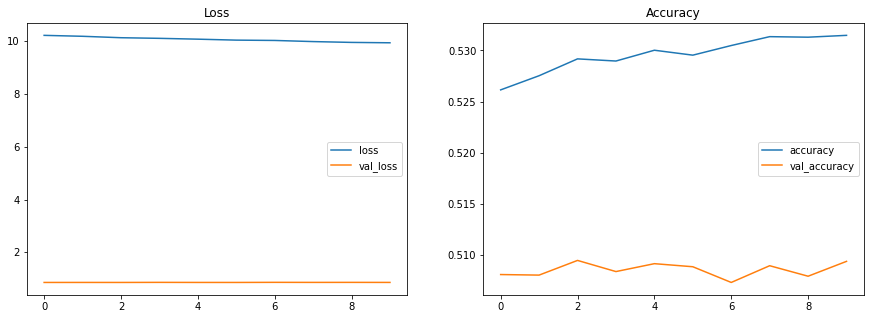

3441/3441 [==============================] - 262s 76ms/step - loss: 0.8579 - accuracy: 0.5094
{'loss': 0.8579386472702026, 'accuracy': 0.509381890296936}


FileNotFoundError: ignored

In [28]:
evaluate_model(
    model, 
    valid, 
    training_results, 
    execution_time, 
    learning_rate, 
    batch_size, 
    epochs, 
    optimizers
)

In [22]:
model.save_weights("weights.h5")

In [26]:
model.save("model.hdf5")

NotImplementedError: ignored